## Conway's Game of Life 

This is an exploration of running Life as a kernel convolution followed by a non-linear activation, which 
allows the use of deep learning framework to run simulations. This notebook shows how this can be done
with PyTorch. 

**Note**: In terms of absolute speed and performance (for sparse configuration with interesting patterns), this method is far behind hash based methods on CPU even when run with GPU. PyTorch F.conv2d(...) works only with Float and Double, which makes this naive implementation memory inefficient. 

* https://www.ibiblio.org/lifepatterns/october1970.html (Scientific American 223 Oct 1970)
* https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life
* http://golly.sourceforge.net (Golly)

### Imports

In [1]:
from pathlib import *
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from fastai.vision import *

# import drawSvg as draw
import IPython
from io import BytesIO
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Utilities

In [2]:
Path.ls = lambda x: list(x.iterdir())
def _describe(self):
    print(f"shape: {self.shape}")
    print(f"dtyle: {self.dtype}")
    print(f"min_val: {torch.min(self)}")
    print(f"max_val: {torch.max(self)}")
    print(f"type: {type(self)}")

torch.Tensor.describe = _describe

### Visualization utilties

In [3]:
def vis_stream(image, index):

    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')

    plt.axis('off')
    plt.title(f'iteration {index}')
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()

### Rule of the Game
A convolution (with bias term) + nonlinear activation. We are choosing this particular implementation so everything is cleanly in integers. This is not a unique choice.

In [21]:
'''
The rule in Conway's Game of Life can be expressed as 2 tensor operations

1) 2D convolution with the following kernel

     2  2  2
     2  1  2
     2  2  2 
     
2) add bias of -5     
    
2) Non-linear activation with this function:

    (z >= 0) * (z <= 2)
    
'''
kernel = 2*torch.ones((3,3)); kernel[1,1] = 1
kernel = kernel[None, None, ...].to(dev)

kernel.describe()
print(kernel)

def evolve(x, k):
    z = F.conv2d(x, k, padding=1) - 5.0
    a = torch.mul(torch.ge(z, 0), torch.le(z, 2))
    return a.float()

def place(pattern, X, at=(0, 0)):
    h = pattern.shape[1]
    w = pattern.shape[0]
    x = at[0]
    y = at[1]
    
    X[x:x+w, y:y+h] = pattern
    
    return X

shape: torch.Size([1, 1, 3, 3])
dtyle: torch.float32
min_val: 1.0
max_val: 2.0
type: <class 'torch.Tensor'>
tensor([[[[2., 2., 2.],
          [2., 1., 2.],
          [2., 2., 2.]]]])


### Oscillators

#### Blinker (period 2)

In [ ]:
x_5_5 = torch.zeros(5, 5)
x_5_5[2,1] = 1
x_5_5[2,2] = 1
x_5_5[2,3] = 1

x_5_5 = x_5_5[None, None, ...].to(dev)
print(x_5_5.shape)
plt.imshow(1-np.squeeze(x_5_5.cpu().numpy()), cmap='gray')

a = x_5_5

#### Toad (period 2) 

In [ ]:
x_6_6 = torch.zeros(6, 6)

x_6_6[2,2] = 1
x_6_6[2,3] = 1
x_6_6[2,4] = 1

x_6_6[3,1] = 1
x_6_6[3,2] = 1
x_6_6[3,3] = 1

x_6_6 = x_6_6[None, None, ...].to(dev)

plt.imshow(1-np.squeeze(x_6_6.cpu().numpy()), cmap='gray')

a = x_6_6

#### Beacon (period 2)

In [ ]:
x_6_6 = torch.zeros(6, 6)

x_6_6[1,1] = 1
x_6_6[1,2] = 1
x_6_6[2,1] = 1
x_6_6[2,2] = 1

x_6_6[3,3] = 1
x_6_6[3,4] = 1
x_6_6[4,3] = 1
x_6_6[4,4] = 1

x_6_6 = x_6_6[None, None, ...].to(dev)

plt.imshow(1-np.squeeze(x_6_6.cpu().numpy()), cmap='gray')

a = x_6_6

### Spaceships

#### Glider

In [ ]:
glider = torch.tensor([[1, 0, 1],
                       [0, 1, 1],
                       [0, 1, 0]], dtype=torch.float32)

In [ ]:
x = torch.zeros(100, 100)
x = place(glider, x, at=(0, 0))

x = place(glider, x, at=(10, 10))

x = x[None, None, ...].to(dev)

plt.imshow(1-np.squeeze(x.cpu().numpy()), cmap='gray')

a = x

#### Light-weight spaceship (LWSS)

In [5]:
LWSS = torch.tensor([[0, 1, 1, 1, 1],
                     [1, 0, 0, 0, 1],
                     [0, 0, 0, 0, 1],
                     [1, 0, 0, 1, 0]], dtype=torch.float32)

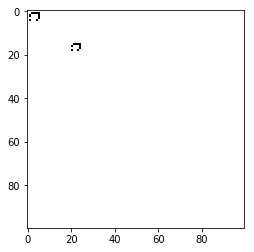

In [37]:
x = torch.zeros(100, 100)
x = place(LWSS, x, at=(1, 1))

x = place(LWSS, x, at=(15, 20))

x = x[None, None, ...].to(dev)

plt.imshow(1-np.squeeze(x.cpu().numpy()), cmap='gray')

a = x

#### Middle-weight spaceship (MWSS)

In [10]:
MWSS = torch.tensor([[0, 1, 1, 0, 0, 0],
                     [1, 1, 0, 1, 1, 1],
                     [0, 1, 1, 1, 1, 1],
                     [0, 0, 1, 1, 1, 0]], dtype=torch.float32)

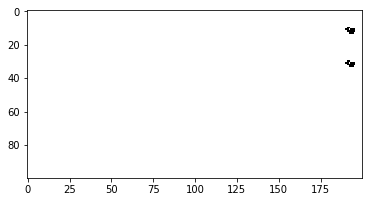

In [32]:
x = torch.zeros(100, 200)
x = place(MWSS, x, at=(10, 190))

x = place(MWSS, x, at=(30, 190))

x = x[None, None, ...].to(dev)

plt.imshow(1-np.squeeze(x.cpu().numpy()), cmap='gray')

a = x

#### Heavy-weight spaceship (HWSS)

In [40]:
HWSS = torch.tensor([[1, 1, 1, 1, 1, 1, 0],
                     [1, 0, 0, 0, 0, 0, 1],
                     [1, 0, 0, 0, 0, 0, 0],
                     [0, 1, 0, 0, 0, 0, 1],
                     [0, 0, 0, 1, 1, 0, 0]], dtype=torch.float32)

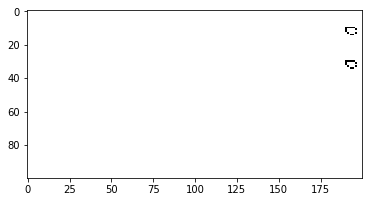

In [41]:
x = torch.zeros(100, 200)
x = place(HWSS, x, at=(10, 190))

x = place(HWSS, x, at=(30, 190))

x = x[None, None, ...].to(dev)

plt.imshow(1-np.squeeze(x.cpu().numpy()), cmap='gray')

a = x

### Gosper glider gun

In [45]:
GGG = torch.tensor([
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],    
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],  
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
], dtype=torch.float32)

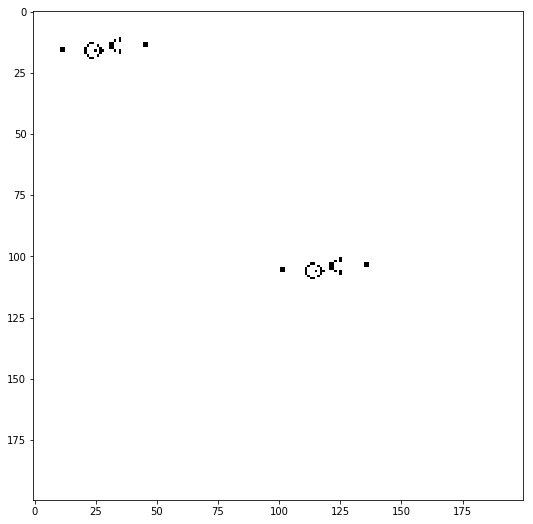

In [50]:
x = torch.zeros(200, 200)
x = place(GGG, x, at=(10, 10))

x = place(GGG, x, at=(100, 100))

x = x[None, None, ...].to(dev)

plt.figure(figsize=(9, 9))
plt.imshow(1-np.squeeze(x.cpu().numpy()), cmap='gray'); 

a = x

### Random

In [ ]:
# x_random = torch.randint(0, 2, (N, 100)).float()
N = 100
x_random = (torch.FloatTensor(N, N).uniform_() > 0.6).float()
x_random = x_random[None, None, ...].to(dev)

plt.grid(); plt.imshow(np.squeeze(1-x_random.cpu().numpy()), cmap='gray')

a = x_random

### Run simulation here

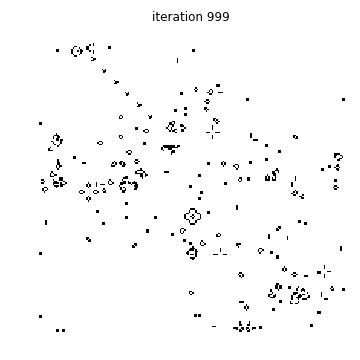

In [62]:
# Setup "a" the initial pattern by running one of the cell in the above section

num_iteration = 1000

try:
    for i in range(num_iteration):
        a = evolve(a, kernel)

#         time.sleep(0.5)        
        vis_stream(1-np.squeeze(a.cpu().numpy()), i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

### Scratch Pad

In [ ]:
# Population space X

X = torch.zeros((2**8,3,3)); X[:,1,1] = 1; X

for i in range(2**8):
    X[i,0,0] = i & 1
    X[i,0,1] = i >> 1 & 1
    X[i,0,2] = i >> 2 & 1
    X[i,1,0] = i >> 3 & 1
    X[i,1,2] = i >> 4 & 1
    X[i,2,0] = i >> 5 & 1
    X[i,2,1] = i >> 6 & 1
    X[i,2,2] = i >> 7 & 1
        
# reshape this into something F.conv2d likes
X = X[:,None,:,:]
X.shape

In [ ]:
# kernel = torch.ones(3, 3); kernel[1, 1] = 0.5
# kernel = kernel[None,None,...]; 

# kernel.describe(); print(kernel)

In [ ]:
# x_test = X[3:4]    # grad 3rd and preserve shape
# x_test = F.pad(x_test, pad=(1, 1, 1, 1), value=0)   #zero padding
# x_test
# F.conv2d(x_test, kernel)

In [ ]:
F.conv2d(X[3:4], kernel, padding=1)
F.threshold(-1*torch.ones(1), 1, 1)
F.hardtanh(5*torch.ones(1), min_val=4, max_val=4)

In [ ]:
z = torch.linspace(0, 17, steps=18); z
torch.mul(torch.ge(z, 5), torch.le(z, 7))

In [ ]:
# X o k2 
x = X[3:4]
print(x)
z = F.conv2d(x, kernel, padding=1)
#print(z)
a = torch.mul(torch.ge(z, 5), torch.le(z, 7))
print(a)

In [ ]:
kernel = torch.ones(3, 1)
kernel = kernel[None, None, ...]

In [ ]:
X = F.conv2d(X[3:4], kernel, padding=1)
X = F.conv2d(X, torch.transpose(kernel, 2, 3), padding=1)

In [ ]:
kernel.shape

In [ ]:
torch.transpose?